In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear


pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
721,1,295.0,NaN,NaN,64.0,176.0,20.661157,107.0,68.0,0.0,79.0,0.0,84.0,0.940476,1.0,1.0,0.448864,0.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0,2.0,NaN,0.0,6.6640,5.152,11.8160,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,5.03,3.06,1.51,0.25,0.14,0.07,60.8,30.0,5.0,2.8,1.4,4.76,12.7,37.1,2.921260,77.9,26.7,34.2,12.8,0.0,247.0,12.4,10.5,29.6,49.105368,0.042510,163.576159,6.040000,2.026490,0.300199,0.027833,144.0,4.18,9.37,4.11,0.77,0.4,15.0,20.0,0.29,184.0,4.75824,0.0,70.0,1.81020,0.0,104.4,2.699784,0.0,47.0,0.53063,0.0,1.491429,0.671429,0.574591,29.727273,11.14323,4.174979,-0.173000,267.0,97.0,363.0,27.0,18.0,90.0,90.0,5.07,38.67,1.126667,10.55,0.376046,0.0,0.0,3.19,4.86,14.00,13.0,10.0,5.2,14.4,2.769231,262.0,297.0,1.7,0.489914,0.012364,124.511764,35.22,463.0,NaN,61.0,137.5,1.21,16.97,4.9,25.0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,31.0
349,1,236.0,23.35,22.969188,55.5,171.0,18.980199,126.0,75.0,0.0,65.0,0.0,85.0,0.764706,0.0,0.0,0.380117,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,5.3580,5.600,10.9580,0.0,0.0,21.8100,34.22,56.0300,1.0,0.0,0.0,6.03,3.90,1.65,0.35,0.05,0.08,64.7,27.4,5.8,0.8,1.3,3.91,12.7,37.6,2.960630,96.2,32.5,33.8,11.8,0.0,228.0,16.4,12.1,42.6,37.810945,0.053070,138.181818,4.714286,2.363636,0.273632,0.008292,143.0,4.10,9.78,3.19,0.61,0.3,19.0,19.0,0.31,179.0,4.62894,0.0,100.0,2.58600,0.0,66.7,1.724862,0.0,60.0,0.67740,0.0,0.667000,0.600000,0.440996,31.707602,4.74180,4.250532,-0.221849,243.0,96.0,339.0,28.0,13.0,82

### Handle `vitamine D ` outliers

In [19]:
df[df[VITAMINE_D] > 80][VITAMINE_D]

df.loc[df[VITAMINE_D] > 80, VITAMINE_D] = None

# Model selection for vitamin D

In [20]:
df_vit_d_cleaned = df.dropna(subset=[VITAMINE_D])

X_vit_d, y_vit_d = df_vit_d_cleaned.drop(columns=[VITAMINE_D]), df_vit_d_cleaned[VITAMINE_D]
X_train_vit_d, X_val_vit_d, y_train_vit_d, y_val_vit_d = train_test_split(X_vit_d, y_vit_d, test_size=0.2, random_state=42)

In [4]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]

#  TODO: run again! Because I removed the outliers

continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}

scores_df = explore_all_variations_of_preprocessing(X_train_vit_d, y_train_vit_d, VITAMINE_D, models, continuous_preprocessings, categorical_preprocessings)

1/48 DecisionTreeRegressor(max_depth=7, random_state=42) PT_iterative_basic original_ohe_no_imputing [-11.90476921 -12.65226769 -12.31686472 -10.55656768 -11.5580557
  -9.41800117 -10.8919422  -12.33285081 -10.67555665 -11.09812074
 -12.02367818 -12.27701292 -10.89089812 -10.59720189 -10.82851312] 11.334820053419348
2/48 Lasso() PT_iterative_basic original_ohe_no_imputing [-8.81745199 -9.52167944 -9.36954261 -8.15745592 -8.22106955 -8.84358762
 -7.88375467 -9.59486355 -9.33921628 -8.75565974 -8.04351661 -9.94918524
 -8.63420873 -8.86894902 -8.50479498] 8.83366239674724
3/48 Ridge() PT_iterative_basic original_ohe_no_imputing [-13.47126241 -11.7344147  -10.96106966  -9.17928757 -10.97744276
 -11.09840066  -9.60126022 -10.79207693 -10.66676512 -11.5721826
 -10.87823474 -10.89774834 -10.47622412 -13.51979905 -10.53027268] 11.090429438106316
4/48 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-9.15611111 -9.45644444 -9.18644444 -8.36011236 -8.6511236  -8.78033333
 -8.

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,"DecisionTreeRegressor(max_depth=7, random_state=42)",11.334820
1,PT_iterative_basic,original_ohe_no_imputing,Lasso(),8.833662
2,PT_iterative_basic,original_ohe_no_imputing,Ridge(),11.090429
3,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),8.951723
4,PT_iterative_basic,original_ohe_+_impute_knn,"DecisionTreeRegressor(max_depth=7, random_state=42)",11.309570
5,PT_iterative_basic,original_ohe_+_impute_knn,Lasso(),8.833662
6,PT_iterative_basic,original_ohe_+_impute_knn,Ridge(),11.204000
7,PT_iterative_basic,original_ohe_+_impute_knn,RandomForestRegressor(),9.056948
8,PT_iterative_basic,original_ohe_+_impute_rf,"DecisionTreeRegressor(max_depth=7, random_state=42)",11.279250
9,PT_iterative_basic,original_ohe_+_impute_rf,Lasso(),8.833662


In [6]:
scores_df = _

In [8]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.106080
                          original_ohe_+_impute_rf     10.134701
                          original_ohe_no_imputing     10.057171
PT_iterative_basic        original_ohe_+_impute_knn    10.101045
                          original_ohe_+_impute_rf     10.086042
                          original_ohe_no_imputing     10.052659
RS_KNN                    original_ohe_+_impute_knn    10.118658
                          original_ohe_+_impute_rf     10.109679
                          original_ohe_no_imputing     10.055548
RS_iterative_basic        original_ohe_+_impute_knn    10.121895
                          original_ohe_+_impute_rf     10.170401
                          original_ohe_no_imputing     10.066486
Name: MAE, dtype: float64

In [9]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                10.099317
PT_iterative_basic    10.079915
RS_KNN                10.094628
RS_iterative_basic    10.119594
Name: MAE, dtype: float64

In [10]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    10.111920
original_ohe_+_impute_rf     10.125206
original_ohe_no_imputing     10.057966
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.364120
Lasso()                                                 8.830515
RandomForestRegressor()                                 8.975628
Ridge()                                                11.223191
Name: MAE, dtype: float64

Best preprocessing techniques for vitamine D:
- PT_iterative_basic  + original_ohe_no_imputing

In [ ]:
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

In [21]:
models = [
        Lasso(),
        RandomForestRegressor(),
        ]

continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}

scores_df = explore_all_variations_of_preprocessing(X_train_vit_d, y_train_vit_d, VITAMINE_D, models, continuous_preprocessings, categorical_preprocessings)
scores_df

1/2 Lasso() PT_iterative_basic original_ohe_no_imputing [-10.26689768  -9.69301099  -8.78730634  -8.13671025  -8.07252033
  -9.28578906  -8.30681608  -9.83809448  -9.17661505  -8.27553036
  -9.26510451  -8.55863839  -8.87885747  -9.03500892  -9.29188159] 8.9912520998578
2/2 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-10.31370787  -9.35348315  -8.58865169  -8.20685393  -8.12314607
  -9.53853933  -8.7094382   -9.88359551  -8.7588764   -8.17146067
  -9.00460674  -8.79764045  -8.82168539  -9.08831461  -9.24393258] 8.973595505617977


,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,Lasso(),8.991252
1,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),8.973596


### Hyperparameter tuning

### Lasso

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=0.1;, score=(train=-7.618, test=-8.872) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=0.1;, score=(train=-7.105, test=-10.018) total time= 2.3min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=0.1;, score=(train=-7.136, test=-9.957) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=0.1;, score=(train=-7.420, test=-9.154) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=0.1;, score=(train=-7.157, test=-9.413) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-8.508, test=-8.678) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-8.253, test=-9.013) total time= 2.2min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-8.487, test=-8.689) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-8.537, test=-8.569) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-8.420, test=-8.933) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-9.171, test=-9.519) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-9.152, test=-9.644) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-9.326, test=-8.977) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-9.359, test=-8.835) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-9.227, test=-9.281) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-9.171, test=-9.519) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-9.152, test=-9.644) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-9.326, test=-8.977) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-9.359, test=-8.835) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-9.227, test=-9.281) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


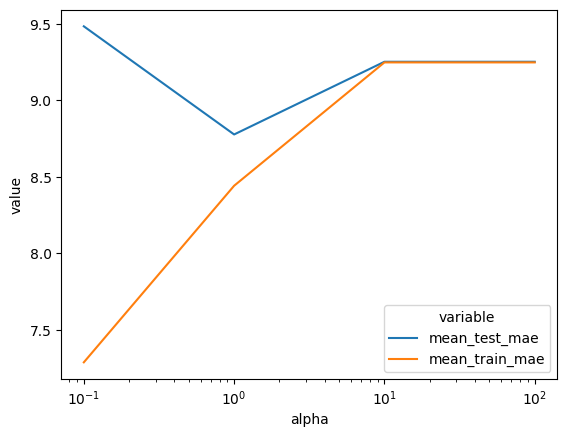

,alpha,mean_test_mae,mean_train_mae
0,0.1,9.482719,7.287089
1,1,8.776057,8.440962
2,10,9.251144,9.246933
3,100,9.251144,9.246933


In [159]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.1, 1, 10, 100],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

### Ridge

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=0.1;, score=(train=-6.677, test=-13.838) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=0.1;, score=(train=-6.402, test=-12.776) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=0.1;, score=(train=-6.332, test=-12.562) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=0.1;, score=(train=-6.576, test=-10.044) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=0.1;, score=(train=-6.200, test=-12.416) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-6.951, test=-10.655) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-6.580, test=-11.748) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-6.560, test=-11.788) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-6.784, test=-9.770) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-6.468, test=-11.274) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-7.305, test=-9.589) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-6.870, test=-10.649) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-6.878, test=-10.573) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-7.111, test=-9.272) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-6.834, test=-9.916) total time= 2.2min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-7.734, test=-8.827) total time= 2.2min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-7.348, test=-9.463) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-7.463, test=-9.588) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-7.621, test=-8.725) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-7.400, test=-9.147) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1000;, score=(train=-8.280, test=-8.733) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1000;, score=(train=-8.159, test=-8.978) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1000;, score=(train=-8.242, test=-8.915) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1000;, score=(train=-8.375, test=-8.428) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1000;, score=(train=-8.163, test=-8.934) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10000;, score=(train=-8.835, test=-9.177) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10000;, score=(train=-8.797, test=-9.336) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10000;, score=(train=-8.937, test=-8.811) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10000;, score=(train=-9.038, test=-8.599) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10000;, score=(train=-8.835, test=-9.049) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


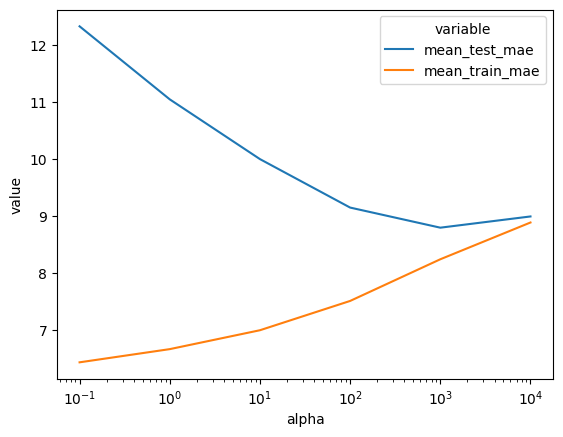

,alpha,mean_test_mae,mean_train_mae
0,0.1,12.327277,6.437382
1,1,11.047088,6.668634
2,10,9.999707,6.999810
3,100,9.150052,7.513340
4,1000,8.797646,8.243757
5,10000,8.994415,8.888438


In [160]:
ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 100, 1000, 10000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

### DecisionTreeRegressor

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__max_depth=2;, score=(train=-8.204, test=-10.056) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__max_depth=2;, score=(train=-8.159, test=-9.783) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__max_depth=2;, score=(train=-8.405, test=-8.933) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__max_depth=2;, score=(train=-8.365, test=-9.506) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__max_depth=2;, score=(train=-8.203, test=-9.629) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__max_depth=3;, score=(train=-7.690, test=-10.122) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__max_depth=3;, score=(train=-7.763, test=-9.856) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__max_depth=3;, score=(train=-7.743, test=-9.489) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__max_depth=3;, score=(train=-7.655, test=-10.775) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__max_depth=3;, score=(train=-7.752, test=-9.685) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__max_depth=4;, score=(train=-7.165, test=-9.567) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__max_depth=4;, score=(train=-7.489, test=-10.300) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__max_depth=4;, score=(train=-7.115, test=-10.333) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__max_depth=4;, score=(train=-6.755, test=-11.213) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__max_depth=4;, score=(train=-7.281, test=-9.770) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__max_depth=5;, score=(train=-6.553, test=-10.122) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__max_depth=5;, score=(train=-7.056, test=-9.922) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__max_depth=5;, score=(train=-6.307, test=-10.144) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__max_depth=5;, score=(train=-6.045, test=-11.657) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__max_depth=5;, score=(train=-6.635, test=-9.949) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__max_depth=7;, score=(train=-4.955, test=-10.139) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__max_depth=7;, score=(train=-5.709, test=-11.378) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__max_depth=7;, score=(train=-5.335, test=-10.361) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__max_depth=7;, score=(train=-4.886, test=-12.365) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__max_depth=7;, score=(train=-5.421, test=-10.449) total time= 2.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


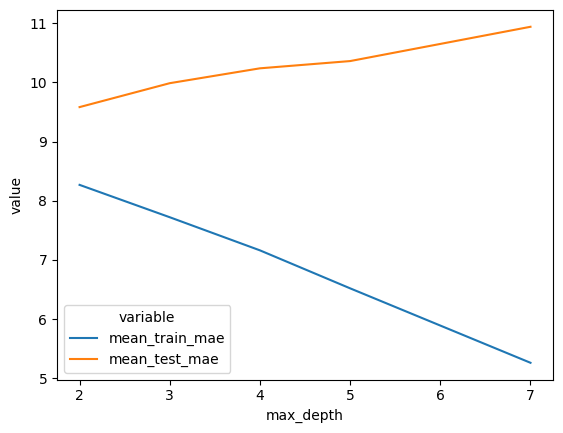

,max_depth,mean_train_mae,mean_test_mae
0,2,8.267280,9.581411
1,3,7.720443,9.985468
2,4,7.160874,10.236629
3,5,6.519173,10.359126
4,7,5.261281,10.938477


In [34]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", min_samples_leaf=5, random_state=42)

tree_param_grid = {
    "model__max_depth": [2, 3, 4, 5, 7], # 10 and higher cause train_mae to be 0
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning(vit_d, tree_model, tree_param_grid, 'max_depth')
vit_d_tree_model_hyperparam_tuning_df

In [131]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [2, 4, 6],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_tree(X_train_vit_d, y_train_vit_d, vit_d, tree_model, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,params,mean_train_mae,mean_test_mae
14,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.647858,8.908702
41,"{'model__criterion': 'friedman_mse', 'model__max_depth': 4, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",8.249767,9.102340
2,"{'model__criterion': 'squared_error', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.782873,9.127765
12,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.637267,9.142472
15,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",8.592711,9.145905
38,"{'model__criterion': 'friedman_mse', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.762984,9.149098
13,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",8.578147,9.151011
1,"{'model__criterion': 'squared_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",8.801389,9.157894
26,"{'model__criterion': 'poisson', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.788706,9.163412
27,"{'model__criterion': 'poisson', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",8.724113,9.175034


In [ ]:
import nest_asyncio
nest_asyncio.apply()

def compare_random_states(X_train, y_train, model, target_attribute):
    random_options = range(1,100)

    tune_df = pd.DataFrame(index=random_options, columns=['cv_mae'])

    for random_o in tqdm(random_options):
        attributes_to_scale = get_continuous_attributes_except(target_attribute)
        imputer = Imputer(IterativeImputer(max_iter=20, tol=0.01, initial_strategy='median'),
                    KNNImputer(n_neighbors=1),
                    attributes_to_scale,
                    CATEGORICAL_ATTRIBUTES)

        one_hot_encoder = CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)
        
        model.set_params(random_state=random_o)
        
        pipeline = Pipeline([('imputer', imputer), ('one_hot_encoder', one_hot_encoder), ('model', model)])

        cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

        tune_df.at[random_o,'cv_mae'] = cv_score.mean()

    return tune_df


model = DecisionTreeRegressor(criterion="absolute_error", max_depth=2, min_samples_leaf=20, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, vit_d)

In [81]:
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

,cv_mae
41,-8.855443
11,-8.900574
95,-8.918115
75,-8.941773
72,-8.945843


## Best models for Vitamine D

In [121]:
def get_feature_importance_lasso(pipeline: Pipeline, target_attribute, significance_threshold=0.1):
    lasso_coefs = pipeline['model'].coef_
    column_names = pipeline['one_hot_encoder'].get_feature_names_out()

    feature_importnces_lasso = [*zip(column_names, lasso_coefs)]
    feature_importances = pd.DataFrame(feature_importnces_lasso, columns=['feature', 'importance'])
    feature_importances_sorted = feature_importances[feature_importances['importance'].abs() > significance_threshold].sort_values(by='importance', key=abs, ascending=False)

    sns.barplot(feature_importances_sorted.head(20), x="importance", y="feature").set(title=target_attribute)
    plt.show()

    return feature_importances_sorted


def get_feature_importance_tree(pipeline: Pipeline, target_attribute, significance_threshold=0):
    feature_importances = pipeline['model'].feature_importances_
    column_names = pipeline['one_hot_encoder'].get_feature_names_out()

    feature_importnces_with_columns = [*zip(column_names, feature_importances)]
    feature_importances_df = pd.DataFrame(feature_importnces_with_columns, columns=['feature', 'importance'])
    feature_importances_sorted = feature_importances_df[feature_importances_df['importance'].abs() > significance_threshold].sort_values(by='importance', key=abs, ascending=False)

    sns.barplot(feature_importances_sorted, x="importance", y="feature").set(title=target_attribute)
    plt.show()

    plot_tree(pipeline['model'], feature_names=column_names)
    plt.savefig(f'charts/decision_tree_.pdf')
    plt.show()

    return feature_importances_sorted


def show_plots(y_true, y_pred, dataset_label):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0],
        random_state=42,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=42,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle(f"Predictions on a {dataset_label} set")
    plt.tight_layout()
    plt.show()


def train_model(model, target_attribute, feature_importance_method):
    model_scores_df = pd.DataFrame(columns=['model', 'test_set', 'mse', "mae", "rmse", 'r2'])
    # drop rows with missing target_attribute
    cleaned_df = df.dropna(subset=[target_attribute])
    
    X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    attributes_to_scale = get_continuous_attributes_except(target_attribute)
    scaler = Scaler(PowerTransformer(), attributes_to_scale)
        
    imputer = Imputer(IterativeImputer(max_iter=50, tol=0.01, initial_strategy='median'),
                    KNNImputer(n_neighbors=1),
                    attributes_to_scale,
                    CATEGORICAL_ATTRIBUTES)
    
    one_hot_encoder = CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)
    
    pipeline = Pipeline([('scaler', scaler), ('imputer', imputer), ('one_hot_encoder', one_hot_encoder), ('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_val = pipeline.predict(X_val)

    train_mse = round(mean_squared_error(y_train, y_pred_train), 3)
    train_mae = round(mean_absolute_error(y_train, y_pred_train), 3)
    train_rmse = round(root_mean_squared_error(y_train, y_pred_train), 3)
    train_r2 = round(r2_score(y_train, y_pred_train), 3)

    val_mse = round(mean_squared_error(y_val, y_pred_val), 3)
    val_mae = round(mean_absolute_error(y_val, y_pred_val), 3)
    val_rmse = round(root_mean_squared_error(y_val, y_pred_val), 3)
    val_r2 = round(r2_score(y_val, y_pred_val), 3)

    show_plots(y_train, y_pred_train, 'training')
    show_plots(y_val, y_pred_val, 'validation')


    model_scores_df.loc[len(model_scores_df)] = [str(model), 'training', train_mse, train_mae, train_rmse, train_r2]
    model_scores_df.loc[len(model_scores_df)] = [str(model), 'validation', val_mse, val_mae, val_rmse, val_r2]


    feature_importnces = feature_importance_method(pipeline, target_attribute)
    
    return model_scores_df, feature_importnces

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


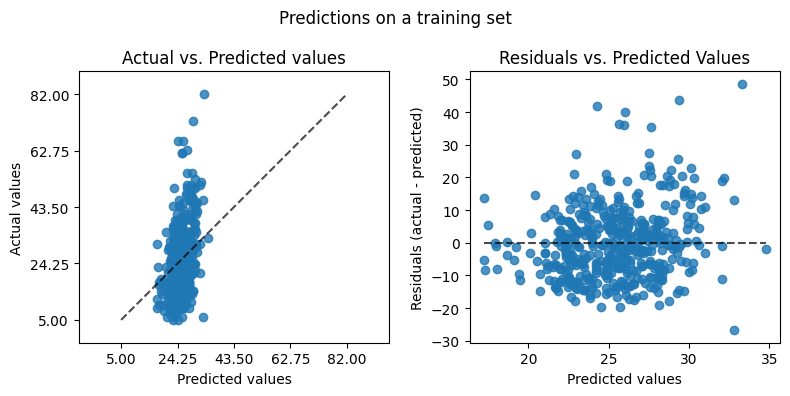

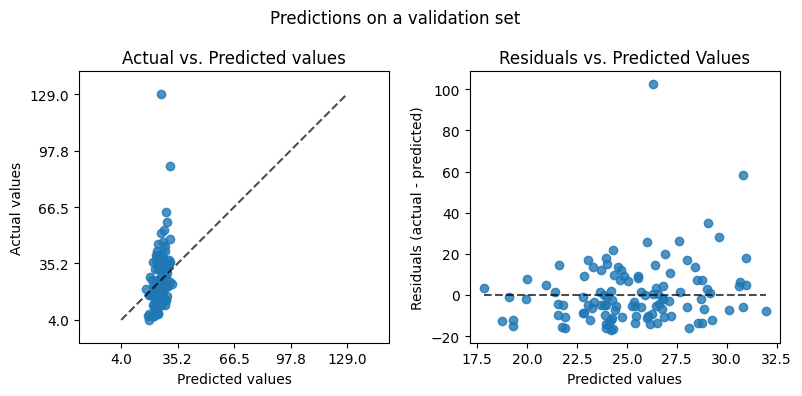

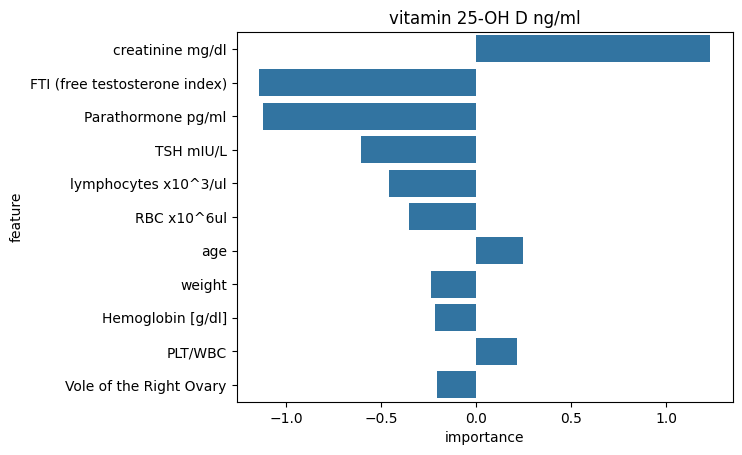

,model,test_set,mse,mae,rmse,r2
0,Lasso(alpha=1),training,120.051,8.510,10.957,0.146
1,Lasso(alpha=1),validation,248.881,10.486,15.776,0.099


In [173]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, vit_d, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


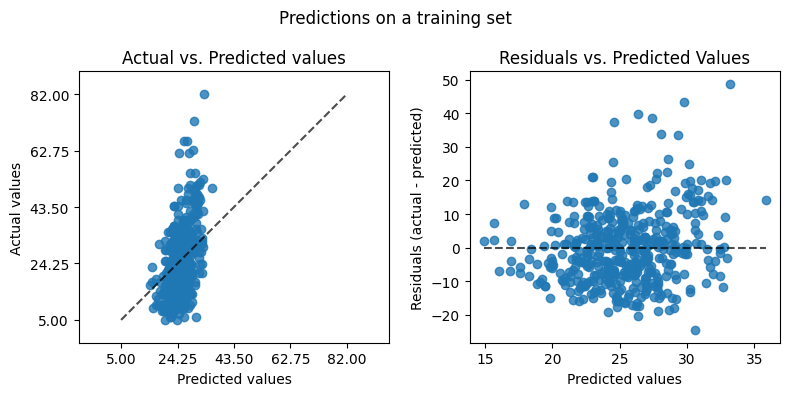

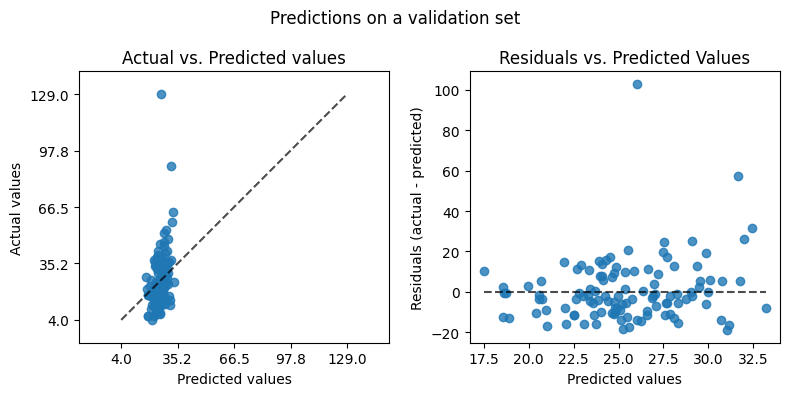

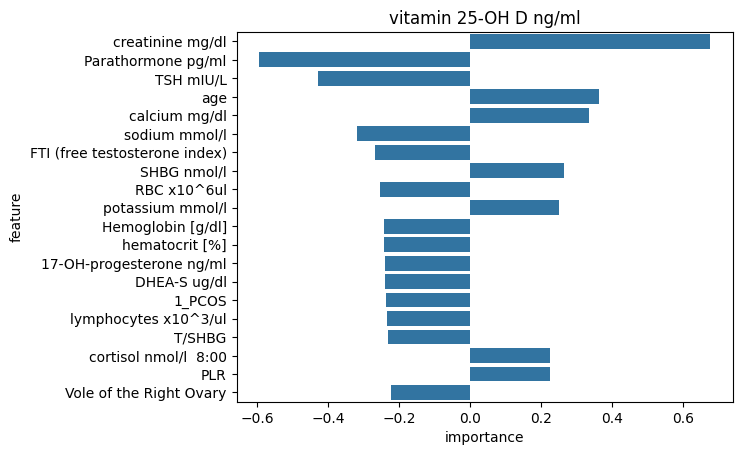

,model,test_set,mse,mae,rmse,r2
0,Ridge(alpha=1000),training,113.844,8.265,10.670,0.190
1,Ridge(alpha=1000),validation,246.682,10.440,15.706,0.107


In [140]:
ridge_model = Ridge(alpha=1000)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, vit_d, get_feature_importance_lasso)
vit_d_model_scores_df

In [141]:
feature_importnces_ridge

,feature,importance
54,creatinine mg/dl,0.674819
100,Parathormone pg/ml,-0.595077
86,TSH mIU/L,-0.428180
113,age,0.362338
52,calcium mg/dl,0.334873
50,sodium mmol/l,-0.318920
105,FTI (free testosterone index),-0.269709
104,SHBG nmol/l,0.264808
30,RBC x10^6ul,-0.255666
51,potassium mmol/l,0.248672


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


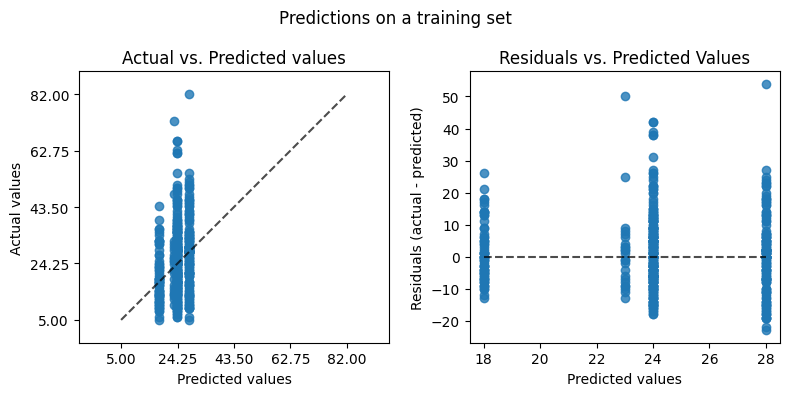

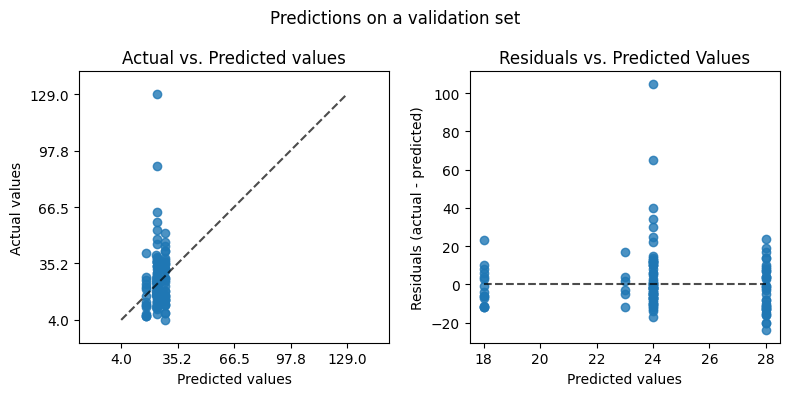

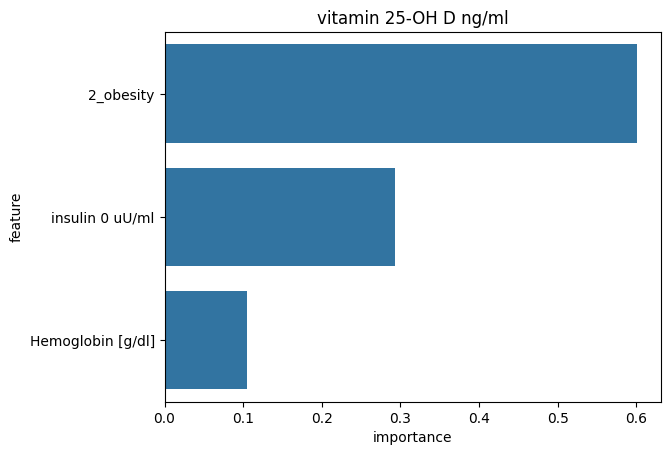

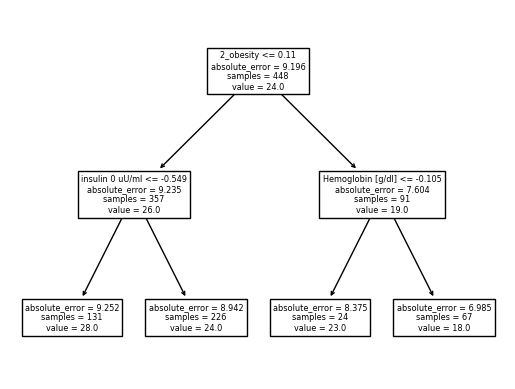

,model,test_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=2,\n min_samples_leaf=20, min_samples_split=15,\n random_state=41, splitter='random')",training,134.312,8.710,11.589,0.045
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=2,\n min_samples_leaf=20, min_samples_split=15,\n random_state=41, splitter='random')",validation,275.080,10.812,16.586,0.004


In [133]:
tree_model = DecisionTreeRegressor(criterion='absolute_error', splitter='random', max_depth=2, min_samples_leaf=20, min_samples_split=15, random_state=41)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, vit_d, get_feature_importance_tree)
vit_d_model_scores_df

Most important attributes for `vitamin D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)'